# Species classification

In [1]:
import tensorflow as tf
import os

#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
#os.environ["CUDA_VISIBLE_DEVICES"]="0"; 
#gpus = tf.config.experimental.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(gpus[0], True)

In [2]:
import keras
import pandas as pd
from PIL import Image
import PIL
#from keras_preprocessing.image import ImageDataGenerator
#from sklearn.model_selection import train_test_split
#from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
#from tensorflow.keras.models import Model
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import efficientnet.keras as efficientnet
from keras_applications import *
import glob
from sklearn.utils import shuffle
from tensorflow import keras
from PIL import ImageFile


# ensure that truncated images dont throw exception
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [5]:
df_data = pd.read_csv('./train_data.csv')
df_data_augmented = pd.read_csv('./train_data_augmented.csv')

In [6]:
df_train = df_data[:2200]
df_test = df_data[2200:]

df_train_augemented = df_data_augmented[:10000]
df_test_augemented = df_data_augmented[10000:]

print(df_train.shape, df_test.shape)

print(df_train_augemented.shape, df_test_augemented.shape)

(2200, 4) (457, 4)
(10000, 4) (2800, 4)


In [7]:
df_train_augemented['label_species'].value_counts()

tomato     3309
soybean    2577
apple      1069
peach      1012
potato      645
corn        595
squash      413
grape       380
Name: label_species, dtype: int64

In [8]:
df_test_augemented['label_species'].value_counts()

tomato     897
soybean    750
peach      300
apple      282
potato     191
corn       163
squash     122
grape       95
Name: label_species, dtype: int64

In [9]:
# early stopping to prevent overfitting
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [10]:
# ImageDataGenerator to pass data from df into NN
# augmentation parameters in ImageDataGenerator are not nessecary due to manually augmentation of original images
datagen = ImageDataGenerator(rescale=1./255,
#                            horizontal_flip=True, 
#                            rotation_range=20,
#                            shear_range=0.1
                            )

In [11]:
train_generator = datagen.flow_from_dataframe(
    dataframe = df_train_augemented,
    directory = None,
    x_col = 'filename', 
    y_col = 'label_species', 
    class_mode = 'categorical',
    target_size=(224,224), 
    batch_size=32)

Found 9993 validated image filenames belonging to 8 classes.


/home/vlba/anaconda3/envs/env_mv/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 7 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [12]:
valid_generator = datagen.flow_from_dataframe(
    dataframe = df_test_augemented,
    directory = None,
    x_col = 'filename', 
    y_col = 'label_species', 
    class_mode = 'categorical',
    target_size=(224,224), 
    batch_size=1)

Found 2797 validated image filenames belonging to 8 classes.


/home/vlba/anaconda3/envs/env_mv/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 3 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [13]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VAL=valid_generator.n//valid_generator.batch_size

In [17]:
# use base model and append own classification layers on top
base_model = efficientnet.EfficientNetB0(weights='imagenet', include_top=False,
                                         backend=tf.keras.backend,
                                         layers=tf.keras.layers,
                                         models=tf.keras.models,
                                         utils=tf.keras.utils)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x)  
x = Dense(512,activation='relu')(x) 
preds = Dense(len(df_test_augemented['label_species'].value_counts()),activation='softmax')(x) 
model = Model(inputs = base_model.input, outputs = preds)


# train only appended head 
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history1 = model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_steps = STEP_SIZE_VAL,
    workers=8,
    callbacks=[callback]
)


# train all except first 100 layers
# len(model.layers) = 239
for layer in model.layers[:100]:
    layer.trainable = False
for layer in model.layers[100:]:
    layer.trainable = True
    
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history2 = model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    epochs=15,
    steps_per_epoch=STEP_SIZE_TRAIN,
    validation_steps = STEP_SIZE_VAL,
    workers=8, 
    callbacks=[callback]
)

mi
Epoch 1/15
312/312 [==============================] - 173s 543ms/step - loss: 0.9564 - accuracy: 0.6728 - val_loss: 0.4920 - val_accuracy: 0.8255
Epoch 2/15
312/312 [==============================] - 168s 534ms/step - loss: 0.4492 - accuracy: 0.8519 - val_loss: 0.3939 - val_accuracy: 0.8670
Epoch 3/15
312/312 [==============================] - 169s 539ms/step - loss: 0.3038 - accuracy: 0.8974 - val_loss: 0.3248 - val_accuracy: 0.8924
Epoch 4/15
312/312 [==============================] - 167s 534ms/step - loss: 0.2189 - accuracy: 0.9269 - val_loss: 0.2834 - val_accuracy: 0.9045
Epoch 5/15
312/312 [==============================] - 168s 536ms/step - loss: 0.1687 - accuracy: 0.9421 - val_loss: 0.2785 - val_accuracy: 0.9067
Epoch 6/15
312/312 [==============================] - 168s 537ms/step - loss: 0.1483 - accuracy: 0.9538 - val_loss: 0.3105 - val_accuracy: 0.9035
Epoch 7/15
312/312 [==============================] - 169s 539ms/step - loss: 0.1299 - accuracy: 0.9589 - val_loss: 0.291

In [18]:
model.save('model_species_reduces_labels_augmented.h5')

# Evaluation

### plots

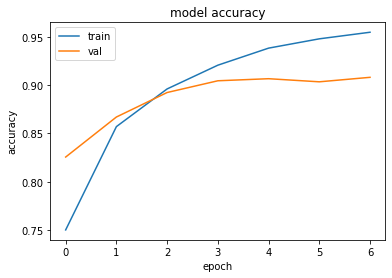

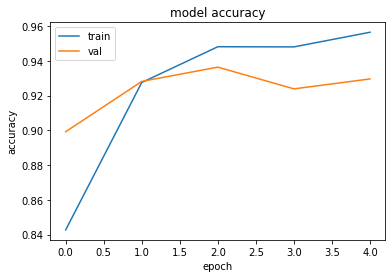

<Figure size 432x288 with 0 Axes>

In [19]:
#plot acc
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('species_acc_hist1.png')

plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('species_acc_hist2.png')

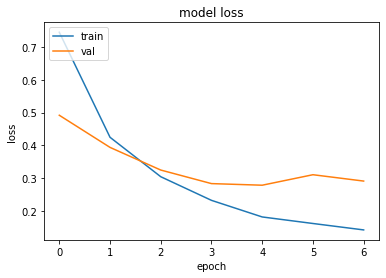

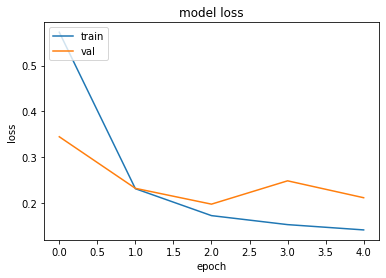

In [20]:
#plot loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
plt.savefig('species_loss_hist1.png')

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('foo.png')
plt.savefig('species_loss_hist2.png')

### confusion matrix

In [21]:
import efficientnet.tfkeras
from tensorflow.keras.models import load_model
model = load_model('./model_species_reduces_labels_augmented.h5')

In [22]:
y_true = []
y_pred = []

label_map = (valid_generator.class_indices)
for index, row in df_test_augemented.iterrows():
    im = Image.open(row["filename"]).convert('RGB') 
    im = im.resize((224,224))
    im = np.asarray(im).astype(float) / 255.
    y_true.append(row['label_species'])
    pred = model.predict(im.reshape((1,)+ (224,224,3)))
    y_pred.append(list(label_map.keys())[list(label_map.values()).index(np.argmax(pred[0]))])

In [23]:
from sklearn.metrics import classification_report, confusion_matrix

print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))

print('Classification Report')
print(classification_report(y_true, y_pred))

Confusion Matrix
[[253   1   5   7   3   5   0   8]
 [  1 152   0   1   4   4   0   1]
 [  0   0  89   1   0   0   0   5]
 [ 11   0   1 266   3   4   2  13]
 [  2   0   0   4 159   0   0  26]
 [  0   0   0   4  36 688   0  22]
 [  3   0   0   0   2   0 109   8]
 [  3   0   1  26  13   6   0 848]]
Classification Report
              precision    recall  f1-score   support

       apple       0.93      0.90      0.91       282
        corn       0.99      0.93      0.96       163
       grape       0.93      0.94      0.93        95
       peach       0.86      0.89      0.87       300
      potato       0.72      0.83      0.77       191
     soybean       0.97      0.92      0.94       750
      squash       0.98      0.89      0.94       122
      tomato       0.91      0.95      0.93       897

    accuracy                           0.92      2800
   macro avg       0.91      0.91      0.91      2800
weighted avg       0.92      0.92      0.92      2800

